In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Get Data

In [2]:
breath_df = pd.read_pickle('breath_pickle')
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [3]:
# Use subset of data for now
under2 = under2[0:100]

## Define Split Trace Function

In [4]:
# Test split trace function is working properly
t = [1,2,3, 4,5, 6, 7, 8, 9, 10]
sliding_split_trace(t, 3, 3)

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[4, 5, 6],
        [7, 8, 9]]))

In [5]:
sliding_split_trace(t, 2, 3)

(array([[1, 2],
        [4, 5]]),
 array([[3, 4, 5],
        [6, 7, 8]]))

In [6]:
sliding_split_trace(t, 1, 2)

(array([[1],
        [3],
        [5],
        [7]]),
 array([[2, 3],
        [4, 5],
        [6, 7],
        [8, 9]]))

## Create Windowed Data

In [7]:
num_outputs=10

In [8]:
df = create_sliding_window_data(n_steps=100, num_outputs=num_outputs, dataset=under2['Trace'])

In [9]:
df.head()

,Trace,Next_pts,Trace_num
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...",0
1,"[0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.002...","[0.3615, 0.3665, 0.3716, 0.3767, 0.3818, 0.386...",0
2,"[0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.002...","[0.4118, 0.4165, 0.4212, 0.4259, 0.4305, 0.435...",0
3,"[0.0041, 0.0049, 0.006, 0.0073, 0.0087, 0.0104...","[0.4581, 0.4626, 0.4672, 0.4717, 0.4762, 0.480...",0
4,"[0.0212, 0.0238, 0.0265, 0.0293, 0.0322, 0.035...","[0.5038, 0.5083, 0.5129, 0.5173, 0.5217, 0.526...",0


## Train Val Test Split

In [10]:
df['Trace_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [11]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [12]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [13]:
scaler = StandardScaler()
# Fit
scaler.fit(list(X_train))
# Transform
x_train = scaler.transform(list(X_train))
x_val = scaler.transform(list(X_val))
x_test = scaler.transform(list(X_test))

In [14]:
print(x_train.shape, x_val.shape, x_test.shape)

(31996, 100) (8133, 100) (23298, 100)


##  Reshape Data

In [15]:
def reshape_trace(trace):
    trace = np.transpose(trace)
    return trace.reshape(trace.shape[0],trace.shape[1], 1)

In [16]:
x_train = reshape_trace(x_train)
x_val = reshape_trace(x_val)
x_test = reshape_trace(x_test)

In [17]:
print(x_train.shape, x_val.shape, x_test.shape)

(100, 31996, 1) (100, 8133, 1) (100, 23298, 1)


In [18]:
y_train2 = reshape_trace(list(y_train))
y_val2 = reshape_trace(list(y_val))
y_test2 = reshape_trace(list(y_test))

## Define Dataset

In [19]:
#dataset
from torch.utils.data import Dataset

In [20]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [21]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)
final_test_dataset = timeseries(x_test,y_val2)

In [22]:
dataset.x.shape

torch.Size([100, 31996, 1])

In [23]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [24]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [25]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [26]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iteraations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Train a model

In [27]:
# mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
# print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
# train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 30, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)
# modname = 'lstm_encode_decode_' + 'sliding'
# torch.save(mymodel, modname)

In [28]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_sliding')

## Plots

In [29]:
# test_preds = gather_preds(mod, final_test_dataset, num_outputs)
# valid_preds = gather_preds(mod, test_dataset, num_outputs)
# train_preds = gather_preds(mod, dataset, num_outputs)

In [30]:
# train['preds'] = train_preds
# valid['preds'] = valid_preds
# test['preds'] = test_preds

In [31]:
# train.to_pickle("train_df_10.pkl")  
# valid.to_pickle("valid_df_10.pkl")  
# test.to_pickle("test_df_10.pkl")  

In [32]:
train = pd.read_pickle("train_df_10.pkl") 
valid = pd.read_pickle("valid_df_10.pkl")  
test = pd.read_pickle("test_df_10.pkl")  

In [33]:
train.head()

,Trace,Next_pts,Trace_num,preds
31431,"[0.0002, 0.0006, 0.001, 0.0017, 0.0025, 0.0037...","[0.7513, 0.7615, 0.7716, 0.7817, 0.7917, 0.801...",51,"[0.72201455, 0.7538945, 0.7719444, 0.7834369, ..."
31432,"[0.0156, 0.0191, 0.0227, 0.0267, 0.0308, 0.035...","[0.8512, 0.8611, 0.8708, 0.8804, 0.89, 0.8996,...",51,"[0.82539, 0.8595345, 0.878423, 0.8896533, 0.89..."
31433,"[0.0612, 0.067, 0.0731, 0.0793, 0.0857, 0.0923...","[0.9482, 0.958, 0.9678, 0.9775, 0.9872, 0.9968...",51,"[0.9248823, 0.95980716, 0.97845507, 0.9886449,..."
31434,"[0.1273, 0.1348, 0.1423, 0.15, 0.1578, 0.1656,...","[1.0432, 1.0522, 1.0611, 1.0699, 1.0787, 1.087...",51,"[1.0232898, 1.0578378, 1.0754147, 1.0840874, 1..."
31435,"[0.2066, 0.2151, 0.2235, 0.232, 0.2405, 0.249,...","[1.1288, 1.1371, 1.1454, 1.1538, 1.1623, 1.170...",51,"[1.1089311, 1.142732, 1.1590221, 1.1662514, 1...."


In [34]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [35]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

In [36]:
test.head(3)

,Trace,Next_pts,Trace_num,preds
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[0.3095, 0.3149, 0.3203, 0.3257, 0.331, 0.3362...",0,"[0.3263498, 0.33325127, 0.3357182, 0.33743763,..."
1,"[0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.002...","[0.3615, 0.3665, 0.3716, 0.3767, 0.3818, 0.386...",0,"[0.37085712, 0.38197088, 0.38704634, 0.3904997..."
2,"[0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.002...","[0.4118, 0.4165, 0.4212, 0.4259, 0.4305, 0.435...",0,"[0.4096427, 0.42437214, 0.43178245, 0.4368205,..."


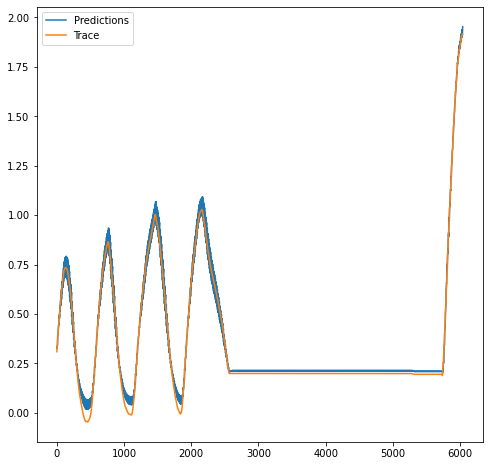

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
trace = np.concatenate(test_pred_trace[0]).ravel().tolist()
plt.plot(trace, '-', label='Predictions')

trace = np.concatenate(test_full_traces[0]).ravel().tolist()
plt.plot(trace, '-', label='Trace')

plt.legend(loc='best')
plt.show()

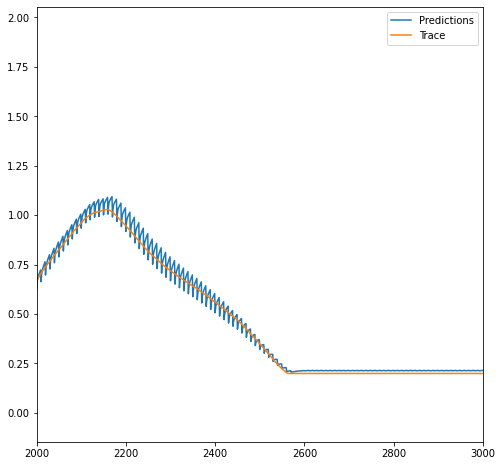

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
trace = np.concatenate(test_pred_trace[0]).ravel().tolist()
plt.plot(trace, '-', label='Predictions')

trace = np.concatenate(test_full_traces[0]).ravel().tolist()
plt.plot(trace, '-', label='Trace')

plt.xlim(2000,3000)
plt.legend(loc='best')
plt.show()

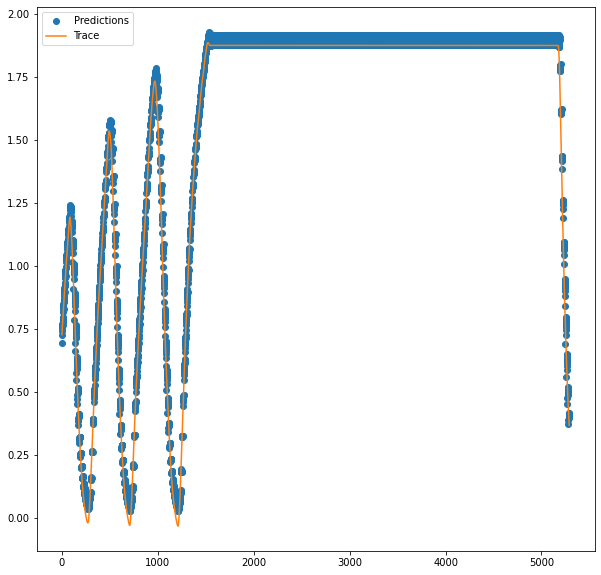

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
trace = np.concatenate(test_pred_trace[19]).ravel().tolist()
plt.plot(trace, 'o', label='Predictions')

trace = np.concatenate(test_full_traces[19]).ravel().tolist()
plt.plot(trace, '-', label='Trace')

plt.legend(loc='best')
plt.show()

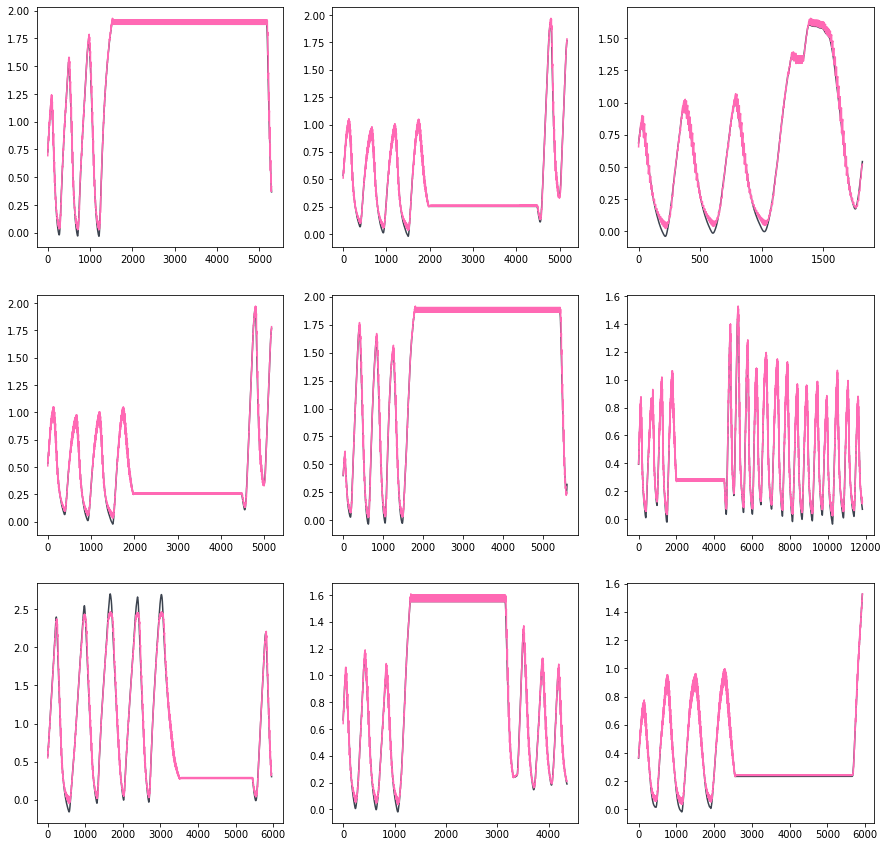

In [40]:
reconstruct_trace(test_full_traces, test_pred_trace)

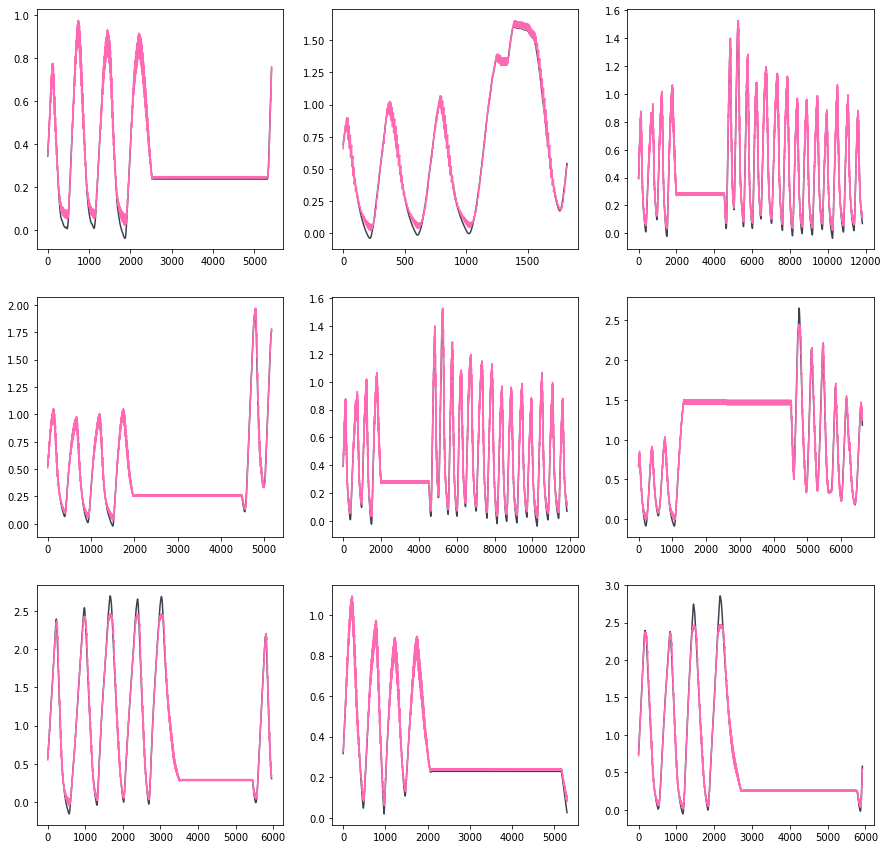

In [41]:
reconstruct_trace(test_full_traces, test_pred_trace)

## Error/Loss 

In [42]:
from collections import defaultdict

In [43]:
errors = defaultdict(list)
for i in range(len(test_pred_trace)):
    for j in range(len(test_pred_trace[i])):
        for k in range(10):
            error = (test_full_traces[i][j][k] - test_pred_trace[i][j][k])**2
            errors[k].append(error)
mse =  defaultdict(int)
for i in range(10):
    mse[i] = np.mean(errors[i])

[]

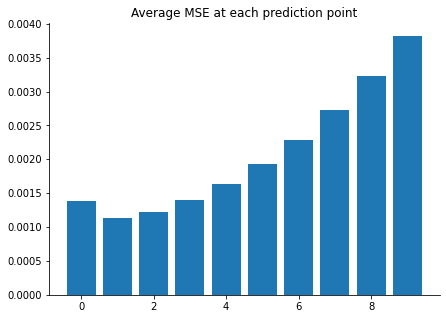

In [136]:
fig, ax = plt.subplots( figsize=(7,5))
ax.bar(mse.keys(), mse.values())
ax.set_title("Average MSE at each prediction point")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot()

In [46]:
errors = []
y = np.concatenate(test_full_traces[19]).ravel().tolist()
pred = np.concatenate(test_pred_trace[19]).ravel().tolist()
for i in range(len(y)):
    error = np.sqrt((y[i]-pred[i])**2)
    errors.append(error)

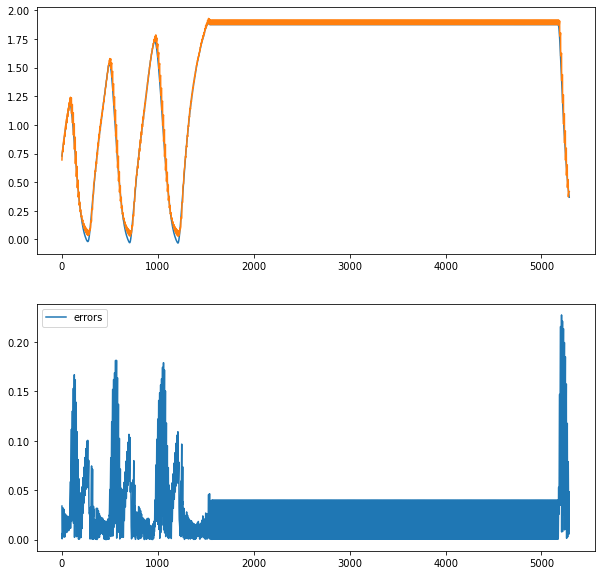

In [48]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

trace = np.concatenate(test_full_traces[19]).ravel().tolist()
ax[0].plot(trace, '-', label='Trace')
trace = np.concatenate(test_pred_trace[19]).ravel().tolist()
ax[0].plot(trace, '-', label='Predictions')
#ax[0].set_xlim(1000,3000)

ax[1].plot(errors, '-', label='errors')
#ax[1].set_xlim(1000,3000)

plt.legend(loc='best')
plt.show()

In [69]:
changes = []
y = np.concatenate(test_full_traces[19]).ravel().tolist()
pred = np.concatenate(test_pred_trace[19]).ravel().tolist()

for i in range(len(y)-10):
    c = []
    for j in range(9):
        d = np.abs(y[i+j+1]-y[i])
        c.append(d)
    changes.append(max(c))
        

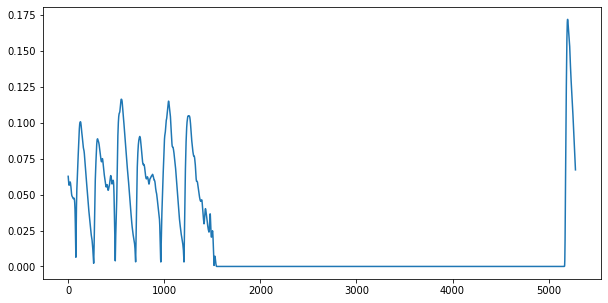

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(changes)
plt.show()